# 02 Strategy Comparison (Case Study)

This notebook runs one full case study and visualizes:
- Performance summary metrics
- Equity curves across strategies
- Drawdown curves
- Black-Litterman rebalance weights


In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT / "src"))

from portfolio_bl.config import load_config
from portfolio_bl.pipeline import run_case_study

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4f}".format


In [2]:
cfg = load_config(ROOT / "configs/case_studies.yaml")
person_key = "buffett"
result = run_case_study(cfg, person_key=person_key, view_confidence=0.65)

print(f"Case study: {result.person_label}")
print(f"Disclosure date: {result.as_of_date.date()}")
print("Universe:", ", ".join(result.universe))


Case study: Warren Buffett
Disclosure date: 2025-03-31
Universe: AAPL, JPM, MSFT, XOM


In [3]:
display_cols = ["annual_return", "annual_volatility", "sharpe", "sortino", "max_drawdown", "hhi", "avg_turnover"]
result.summary[display_cols]


,annual_return,annual_volatility,sharpe,sortino,max_drawdown,hhi,avg_turnover
strategy,,,,,,,
disclosed,0.1179,0.0120,9.7954,NaN,-0.0005,0.3188,0.0000
mean_variance,0.1155,0.0087,13.3025,inf,0.0000,0.4740,0.0022
black_litterman,0.1144,0.0151,7.5576,NaN,-0.0033,0.2788,0.0185


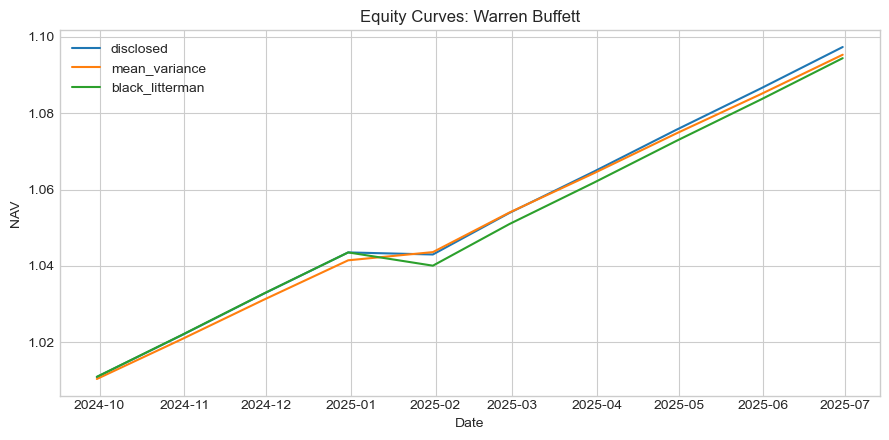

In [4]:
nav_df = pd.DataFrame({name: r.nav for name, r in result.strategy_results.items()}).sort_index()

fig, ax = plt.subplots(figsize=(9, 4.5))
for col in nav_df.columns:
    ax.plot(nav_df.index, nav_df[col], label=col)
ax.set_title(f"Equity Curves: {result.person_label}")
ax.set_xlabel("Date")
ax.set_ylabel("NAV")
ax.legend()
plt.tight_layout()
plt.show()


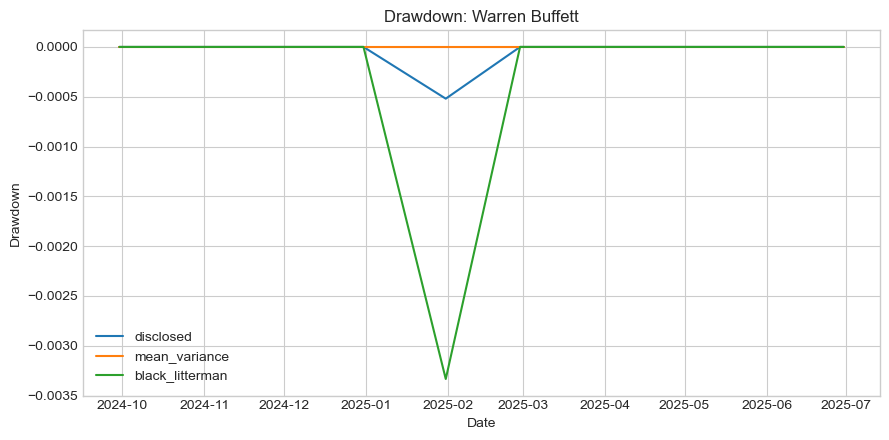

In [5]:
def drawdown(returns: pd.Series) -> pd.Series:
    nav = (1.0 + returns).cumprod()
    peak = nav.cummax()
    return nav / peak - 1.0

dd_df = pd.DataFrame({name: drawdown(r.returns) for name, r in result.strategy_results.items()}).sort_index()

fig, ax = plt.subplots(figsize=(9, 4.5))
for col in dd_df.columns:
    ax.plot(dd_df.index, dd_df[col], label=col)
ax.set_title(f"Drawdown: {result.person_label}")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.legend()
plt.tight_layout()
plt.show()


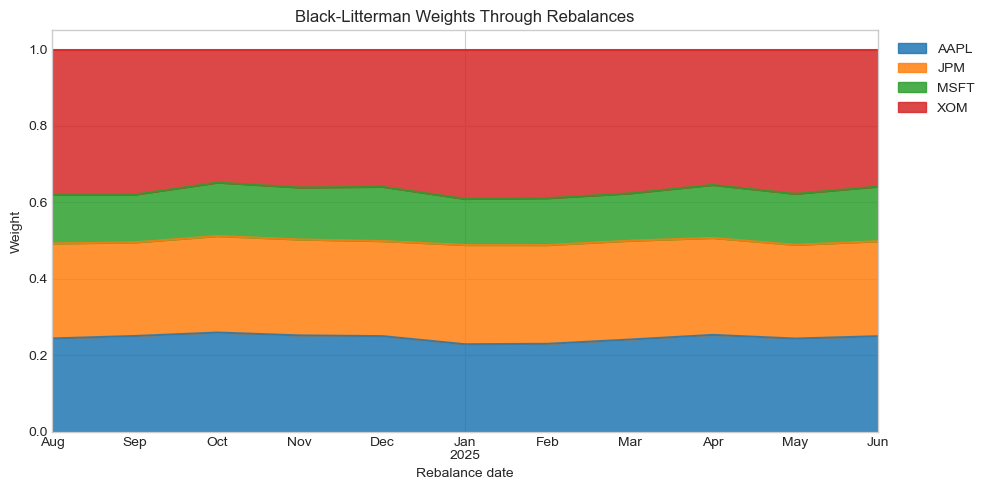

In [6]:
bl_weights = result.strategy_results["black_litterman"].weight_history.copy()

fig, ax = plt.subplots(figsize=(10, 5))
bl_weights.plot.area(ax=ax, alpha=0.85)
ax.set_title("Black-Litterman Weights Through Rebalances")
ax.set_xlabel("Rebalance date")
ax.set_ylabel("Weight")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.show()


In [7]:
metric_cols = ["annual_return", "annual_volatility", "sharpe", "hhi", "avg_turnover"]
summary = result.summary[metric_cols].replace([np.inf, -np.inf], np.nan)
summary


,annual_return,annual_volatility,sharpe,hhi,avg_turnover
strategy,,,,,
disclosed,0.1179,0.0120,9.7954,0.3188,0.0000
mean_variance,0.1155,0.0087,13.3025,0.4740,0.0022
black_litterman,0.1144,0.0151,7.5576,0.2788,0.0185
